## Import python packages and library that will be used

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
import os
import codecs
import matplotlib.image as mpimg
import warnings
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
import shutil

from collections import Counter

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2.9.1


## Read dataset into a dataframe

In [ ]:
# import google drive, the program code can use google drive to read and save files.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# DF = pd.read_csv("./Reviews.csv")
DF = pd.read_csv("/content/drive/MyDrive/Msc project/Reviews.csv")

In [ ]:
# show the dataset
DF

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
# Calculate the number and proportion of data with and without a value of 0 in the HelpfulnessNumerator column
help_list = DF['HelpfulnessNumerator'].values.tolist()
total = len(help_list)
unhelpful = 0
helpful = 0
for i in help_list:
  if i == 0:
    unhelpful = unhelpful + 1
  else:
    helpful = helpful + 1
print('Number of unhelpful reviews: ', unhelpful, '  percentage of unhelpful reviews: ', (unhelpful/total)*100, '%')
print('Number of helpful reviews:   ', helpful, '  percentage of helpful reviews:   ', (helpful/total)*100, '%')

Number of unhelpful reviews:  303826   percentage of unhelpful reviews:  53.447772379119506 %
Number of helpful reviews:    264628   percentage of helpful reviews:    46.552227620880494 %


In [ ]:
# View dataset containing empty value columns
missing_values_count = DF.isnull().sum()
missing_values = missing_values_count.to_frame(name='missing_values_num')
print(missing_values.loc[(missing_values!=0).all(axis=1)])

             missing_values_num
ProfileName                  16
Summary                      27


In [ ]:
# See if there are duplicates data based on 'Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator'.
DF_duplicated = DF.copy()
DF_duplicated = DF_duplicated.drop(labels=['Id','HelpfulnessNumerator','HelpfulnessDenominator'],axis=1)
DF_duplicated

,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
any(DF.duplicated())

False

## Data cleaning
When the HelpfulnessDenominator data is 0, it means that no one has commented on this comment, but it does not mean that this comment is not helpful, so this data needs to be removed.

In [ ]:
# remove the rows where the value in "HelpfulnessDenominator" is 0
DF_clean = DF[DF["HelpfulnessDenominator"] != 0 ]
# show the clean dataset
DF_clean

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
...,...,...,...,...,...,...,...,...,...,...
568440,568441,B005ZC0RRO,A2TO5R8QLIITEF,SAK,1,1,5,1323734400,"Delicious, all natural and allergy free treats!",Indie Candy's gummies are absolutely delicious...
568444,568445,B001EO7N10,A2SD7TY3IOX69B,"BayBay ""BayBay Knows Best""",3,3,5,1245369600,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po..."
568445,568446,B001EO7N10,A2E5C8TTAED4CQ,S. Linkletter,2,2,5,1268006400,Five Spice Powder,"You can make this mix yourself, but the Star A..."
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."


## Label the reviews as helpful/unhelpful

In [ ]:
DF_clean['helpful/unhelpful']= DF_clean.apply(lambda x:1 if x.HelpfulnessNumerator > (x.HelpfulnessDenominator - x.HelpfulnessNumerator + 1) else 0,axis=1)

<ipython-input-17-23f10f5e08c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_clean['helpful/unhelpful']= DF_clean.apply(lambda x:1 if x.HelpfulnessNumerator > (x.HelpfulnessDenominator - x.HelpfulnessNumerator + 1) else 0,axis=1)


In [ ]:
DF_clean

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful/unhelpful
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,0
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,0
...,...,...,...,...,...,...,...,...,...,...,...
568440,568441,B005ZC0RRO,A2TO5R8QLIITEF,SAK,1,1,5,1323734400,"Delicious, all natural and allergy free treats!",Indie Candy's gummies are absolutely delicious...,0
568444,568445,B001EO7N10,A2SD7TY3IOX69B,"BayBay ""BayBay Knows Best""",3,3,5,1245369600,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po...",1
568445,568446,B001EO7N10,A2E5C8TTAED4CQ,S. Linkletter,2,2,5,1268006400,Five Spice Powder,"You can make this mix yourself, but the Star A...",1
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1


In [ ]:
# show the number and persentage of helpful and unhelpful reviews
help_clean = DF_clean['helpful/unhelpful'].values.tolist()
clean_total = len(help_clean)
clean_unhelpful = 0
clean_helpful = 0
for i in help_clean:
  if i == 0:
    clean_unhelpful = clean_unhelpful + 1
  else:
    clean_helpful = clean_helpful + 1
print('Number of unhelpful reviews: ', clean_unhelpful, '  percentage of unhelpful reviews: ', (clean_unhelpful/clean_total)*100, '%')
print('Number of helpful reviews:   ', clean_helpful, ' percentage of helpful reviews:   ', (clean_helpful/clean_total)*100, '%')

Number of unhelpful reviews:  173754   percentage of unhelpful reviews:  58.228162009638005 %
Number of helpful reviews:    124648  percentage of helpful reviews:    41.771837990361995 %


Text(0, 0.5, 'Number')

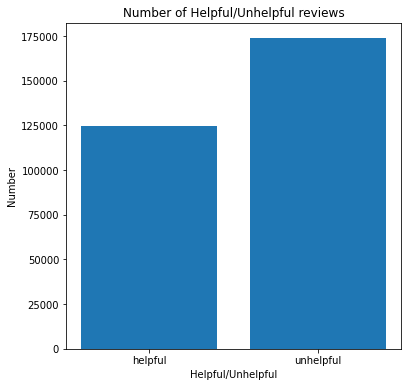

In [ ]:
# use bar chart to show the result
plt.figure(figsize=(6,6))
h_u = []
h_u.append(clean_helpful)
h_u.append(clean_unhelpful)
list_name = ['helpful','unhelpful']
plt.title('Number of Helpful/Unhelpful reviews',fontsize='large')
plt.bar(list_name,h_u)
# plt.xticks(rotation = 90)
plt.xlabel('Helpful/Unhelpful')
plt.ylabel('Number')

Text(0.5, 1.0, 'Percentage of Helpful/Unhelpful reviews')

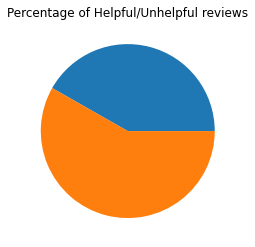

In [ ]:
# use pie chart to show the result
plt.pie(h_u)
plt.title('Percentage of Helpful/Unhelpful reviews',fontsize='large')

In [ ]:
ProductId = DF_clean['ProductId'].values.tolist()
UserId = DF_clean['UserId'].values.tolist()
print(len(ProductId),len(UserId))

298402 298402


In [ ]:
ProductId_uni = list(set(ProductId))
UserId_uni = list(set(UserId))
print(len(ProductId),len(UserId))
print(len(ProductId_uni),len(UserId_uni))

298402 298402
49316 149991


In [ ]:
Product = DF['ProductId'].values.tolist()
User = DF['UserId'].values.tolist()
print(len(Product),len(User))

568454 568454


In [ ]:
Product_uni = list(set(Product))
User_uni = list(set(User))
print(len(Product),len(User))
print(len(Product_uni),len(User_uni))

568454 568454
74258 256059


In [ ]:
# rename the colums for the data processing
data_process = DF_clean[['Text','helpful/unhelpful']]
data_process.rename(columns={'Text' : 'text',
                   'helpful/unhelpful' : 'label'}, 
                    inplace=True)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [ ]:
data_process

,text,label
0,I have bought several of the Vitality canned d...,0
2,This is a confection that has been around a fe...,0
3,If you are looking for the secret ingredient i...,1
8,Right now I'm mostly just sprouting this so my...,0
10,I don't know if it's the cactus or the tequila...,0
...,...,...
568440,Indie Candy's gummies are absolutely delicious...,0
568444,"As a foodie, I use a lot of Chinese 5 Spice po...",1
568445,"You can make this mix yourself, but the Star A...",1
568451,"These stars are small, so you can give 10-15 o...",1


In [ ]:
# data_process['category']= data_process.apply(lambda x:'helpful' if x.label == 0 else: 'unhelpful',axis=1)

In [ ]:
label = data_process['label'].values.tolist()
category = []
for i in label:
    if i == 0:
        category.append('unhelpful')
    else:
        category.append('helpful')

In [ ]:
data_process.insert(1,'category',value=category)

In [ ]:
data_process.reset_index(drop=True, inplace=True)
data_process

,text,category,label
0,I have bought several of the Vitality canned d...,unhelpful,0
1,This is a confection that has been around a fe...,unhelpful,0
2,If you are looking for the secret ingredient i...,helpful,1
3,Right now I'm mostly just sprouting this so my...,unhelpful,0
4,I don't know if it's the cactus or the tequila...,unhelpful,0
...,...,...,...
298397,Indie Candy's gummies are absolutely delicious...,unhelpful,0
298398,"As a foodie, I use a lot of Chinese 5 Spice po...",helpful,1
298399,"You can make this mix yourself, but the Star A...",helpful,1
298400,"These stars are small, so you can give 10-15 o...",helpful,1


In [ ]:
data_process.groupby('label').count()

,text,category
label,,
0,173754,173754
1,124648,124648


In [ ]:
# save the clean dataset into a new csv file
data_process.to_csv('/content/drive/MyDrive/Msc project/dataset_clean.csv',sep=',',index=False)

In [ ]:
data_process

,text,category,label
0,I have bought several of the Vitality canned d...,unhelpful,0
1,This is a confection that has been around a fe...,unhelpful,0
2,If you are looking for the secret ingredient i...,helpful,1
3,Right now I'm mostly just sprouting this so my...,unhelpful,0
4,I don't know if it's the cactus or the tequila...,unhelpful,0
...,...,...,...
298397,Indie Candy's gummies are absolutely delicious...,unhelpful,0
298398,"As a foodie, I use a lot of Chinese 5 Spice po...",helpful,1
298399,"You can make this mix yourself, but the Star A...",helpful,1
298400,"These stars are small, so you can give 10-15 o...",helpful,1


In [ ]:
unhelpful, helpful = np.bincount(data_process['label'])
total = helpful + unhelpful
print('Examples:\n    Total: {}\n    helpful: {} ({:.2f}% of total)\n'.format(
    total, helpful, 100 * helpful / total))
print('Examples:\n    Total: {}\n    unhelpful: {} ({:.2f}% of total)\n'.format(
    total, unhelpful, 100 * unhelpful / total))

Examples:
    Total: 298402
    helpful: 124648 (41.77% of total)

Examples:
    Total: 298402
    unhelpful: 173754 (58.23% of total)



## Split the dataset into train valid and test set

In [ ]:
# split the dataset into train and test set
X_train_, X_test, y_train_, y_test = train_test_split(
    data_process.index.values,
    data_process.label.values,
    test_size=0.10,
    random_state=16,
    stratify=data_process.label.values,    
)

In [ ]:
# split the dataset into train and valid set
X_train, X_val, y_train, y_val = train_test_split(
    data_process.loc[X_train_].index.values,
    data_process.loc[X_train_].label.values,
    test_size=0.10,
    random_state=16,
    stratify=data_process.loc[X_train_].label.values,  
)

In [ ]:
data_process['data_type'] = ['not_set']*data_process.shape[0]
data_process.loc[X_train, 'data_type'] = 'train'
data_process.loc[X_val, 'data_type'] = 'val'
data_process.loc[X_test, 'data_type'] = 'test'

<ipython-input-38-7bf68b6d2869>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_process['data_type'] = ['not_set']*data_process.shape[0]
/usr/lib/python3/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
data_process.groupby(['category', 'label', 'data_type']).count()

text
category  label data_type        
helpful   1     test        12465
                train      100964
                val         11219
unhelpful 0     test        17376
                train      140740
                val         15638

In [ ]:
data_process

,text,category,label,data_type
0,I have bought several of the Vitality canned d...,unhelpful,0,train
1,This is a confection that has been around a fe...,unhelpful,0,train
2,If you are looking for the secret ingredient i...,helpful,1,train
3,Right now I'm mostly just sprouting this so my...,unhelpful,0,train
4,I don't know if it's the cactus or the tequila...,unhelpful,0,train
...,...,...,...,...
298397,Indie Candy's gummies are absolutely delicious...,unhelpful,0,train
298398,"As a foodie, I use a lot of Chinese 5 Spice po...",helpful,1,train
298399,"You can make this mix yourself, but the Star A...",helpful,1,train
298400,"These stars are small, so you can give 10-15 o...",helpful,1,train


In [ ]:
df_train = data_process.loc[data_process["data_type"]=="train"]
df_train.head(10)

,text,category,label,data_type
0,I have bought several of the Vitality canned d...,unhelpful,0,train
1,This is a confection that has been around a fe...,unhelpful,0,train
2,If you are looking for the secret ingredient i...,helpful,1,train
3,Right now I'm mostly just sprouting this so my...,unhelpful,0,train
4,I don't know if it's the cactus or the tequila...,unhelpful,0,train
5,One of my boys needed to lose some weight and ...,helpful,1,train
6,My cats have been happily eating Felidae Plati...,unhelpful,0,train
7,good flavor! these came securely packed... the...,helpful,1,train
9,My daughter loves twizzlers and this shipment ...,helpful,1,train
11,I was so glad Amazon carried these batteries. ...,unhelpful,0,train


In [ ]:
df_val = data_process.loc[data_process["data_type"]=="val"]
df_val

,text,category,label,data_type
8,The Strawberry Twizzlers are my guilty pleasur...,helpful,1,val
16,Instant oatmeal can become soggy the minute th...,helpful,1,val
17,"McCann's Instant Irish Oatmeal, Variety Pack o...",helpful,1,val
83,I read about pomegranate molasses so I had to ...,unhelpful,0,val
87,I have drunk Ricore since my mother allowed be...,helpful,1,val
...,...,...,...,...
298296,I bought them at Shoprite (at 3.79 for a box o...,helpful,1,val
298319,These are fantastic! Very very strong black l...,helpful,1,val
298323,"My wife is Scottish and really misses good ""Br...",helpful,1,val
298332,Fiber One bars are my FAVORITE way of getting ...,unhelpful,0,val


In [ ]:
df_test = data_process.loc[data_process["data_type"]=="test"]
df_test

,text,category,label,data_type
10,"The candy is just red , No flavor . Just plan...",unhelpful,0,test
15,This is a good instant oatmeal from the best o...,helpful,1,test
28,"It is chocolate, what can I say. Great variet...",unhelpful,0,test
34,This stuff really works for preventing crampin...,unhelpful,0,test
39,Buyer Beware Please! This sweetener is not for...,unhelpful,0,test
...,...,...,...,...
298378,I was very pleased with the ingredient quality...,helpful,1,test
298379,My main reason for the five star review has to...,helpful,1,test
298385,"I bought this candy for my son, who spent time...",helpful,1,test
298388,"The candy is tasty, but they totally scam you ...",unhelpful,0,test


In [ ]:
data_process.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

In [ ]:
# transform data into tensor
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [ ]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for feat, targ in test_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'If you want PURE, 100% PALM SUGAR (and there are plenty of options), DO NOT BUY GOLDEN PAK PRODUCTS.<br /><br />I am beyond disappointed, and here is why:<br /><br />INGREDIENTS:<br />Coconut sugar<br />REFINED SUGAR<br />POTASSIUM SORBATE-->the stuff they add to cheap brands of red wine vinegar and loads of processed foods; not the worst by far, but they couldn\'t leave it at that :(<br />SODIUM (aka disodium) METABISULFITE-->E223 for countries that require chemical additives to be labeled (ie not the USA)--see below<br /><br />What\'s worse is they are distributed out of Kent, WA!! Just a stone\'s throw from Amazon HQ! Seattle\'s supposed to be a bit better than this!<br /><br />There\'s PLENTY of REAL palm sugar out there--I\'ve been using the stuff--pure, plain, preservative-free, CANE SUGAR FREE palm/coconut sugar, and THIS ISN\'T IT.<br /><br />Every benefit of palm sugar--and most things--gets totally lost when you (in ascending importance)<br /><br />1) ruin the fl

## Use BERT to pre-processing the data

In [ ]:
# load pre-processing and BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    reviews = text_batch.numpy()[i]
    print(f'Reviews: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')
text_test = [reviews]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Reviews: b"These are very very good tasting. Crispy cookies, especially delicious when dipped in milk. They say gluten free, and I totally believe they are, because I did not have a wheat-type reaction. But, I have to say, I always feel MISERABLE after eating these cookies.<br />Someone else mentions how they are too sweet, etc etc. I don't think they taste too sweet, and they have 13g of sugar per serving which doesn't seem like it's that much, considering most other 'sweets' have more sugars per serving (take a look at Gatorade, for example).<br />That said, it does seem to be some kind of a reaction to the sugar, because immediately after eating them I feel like my body is dumping into some kind of sugar coma. I start to feel like lead, and lightheaded. They also mess up my tummy. Maybe it's the type of sugar they use? Evaporated cane juice is the 1st ingredient, and they also contain 2 kinds of cellulose, which I think are sugars also (but I could be wrong).<br />Anyhow, I gave 4 s

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# use BERT to preprocessing the reviews feature victor
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.1362212  -0.4140933   0.7284374  -0.02461981  0.4962015  -0.9999633
  0.38094863  0.64883775 -0.28359783  0.3192874   0.2665477   0.8321404 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.23030566  1.1216165  -0.25991145 ... -0.13162059  0.13089348
   0.15106387]
 [ 0.12715214  0.12793119  0.4510724  ... -0.20547312 -0.22795019
   0.416003  ]
 [-0.5270223  -0.16219904  0.14979494 ...  0.24309061  0.03191535
  -0.38560492]
 ...
 [-0.49010515  0.35011417  0.49489075 ... -0.35206726  0.06831433
  -0.38681358]
 [ 0.08694478  0.28056896  0.33242583 ... -0.18619902  0.19423707
  -0.25848114]
 [-0.71181244  0.3062802  -0.22636588 ...  1.490515    0.09562337
  -0.85496557]]


## Build and train the CNN. Use CNN to classify the reviews.

In [ ]:
# build classifier model
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    net = sequence_output = outputs["sequence_output"]
    # print(outputs["sequence_output"])
    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    # print(net.shape)
    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    # print(net.shape)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    # print(net.shape)
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    # print(net.shape)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation="softmax", name='classifier')(net)
    # print(net.shape)
    
    return tf.keras.Model(text_input, net)

In [ ]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5513312 0.6886787]], shape=(1, 2), dtype=float32)


In [ ]:
text_test

[b"These are very very good tasting. Crispy cookies, especially delicious when dipped in milk. They say gluten free, and I totally believe they are, because I did not have a wheat-type reaction. But, I have to say, I always feel MISERABLE after eating these cookies.<br />Someone else mentions how they are too sweet, etc etc. I don't think they taste too sweet, and they have 13g of sugar per serving which doesn't seem like it's that much, considering most other 'sweets' have more sugars per serving (take a look at Gatorade, for example).<br />That said, it does seem to be some kind of a reaction to the sugar, because immediately after eating them I feel like my body is dumping into some kind of sugar coma. I start to feel like lead, and lightheaded. They also mess up my tummy. Maybe it's the type of sugar they use? Evaporated cane juice is the 1st ingredient, and they also contain 2 kinds of cellulose, which I think are sugars also (but I could be wrong).<br />Anyhow, I gave 4 stars for

In [ ]:
# show the model details
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

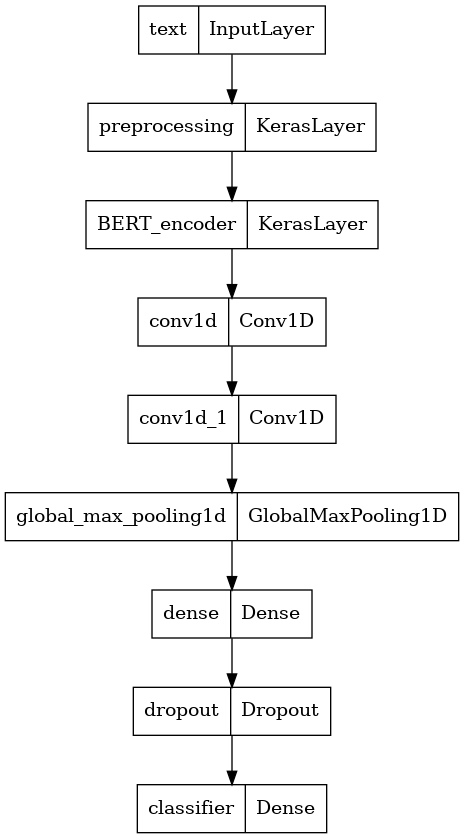

In [ ]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [ ]:
# set the parameters
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 0.00005
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [ ]:
# train and valid the model
print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Epoch 1/20


/home/ubuntu/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7554/7554 [==============================] - 2179s 286ms/step - loss: 0.6632 - accuracy: 0.5994 - val_loss: 0.6338 - val_accuracy: 0.6359
Epoch 2/20
7554/7554 [==============================] - 2161s 286ms/step - loss: 0.6031 - accuracy: 0.6679 - val_loss: 0.5896 - val_accuracy: 0.6783
Epoch 3/20
7554/7554 [==============================] - 2163s 286ms/step - loss: 0.5199 - accuracy: 0.7357 - val_loss: 0.5635 - val_accuracy: 0.6929
Epoch 4/20
7554/7554 [==============================] - 2156s 285ms/step - loss: 0.4239 - accuracy: 0.7973 - val_loss: 0.5530 - val_accuracy: 0.7158
Epoch 5/20
7554/7554 [==============================] - 2158s 285ms/step - loss: 0.3507 - accuracy: 0.8428 - val_loss: 0.7626 - val_accuracy: 0.7271
Epoch 6/20
7554/7554 [==============================] - 2159s 286ms/step - loss: 0.2800 - accuracy: 0.8812 - val_loss: 0.6672 - val_accuracy: 0.7150
Epoch 7/20
7554/7554 [==============================] - 2160s 286ms/step - loss: 0.2180 - accuracy: 0.9131 - val_loss

In [ ]:
# use the model on test set and classify the reviews
loss, accuracy = cnn_classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

933/933 [==============================] - 131s 140ms/step - loss: 2.0864 - accuracy: 0.7305
Loss: 2.086376428604126
Accuracy: 0.7304714918136597


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


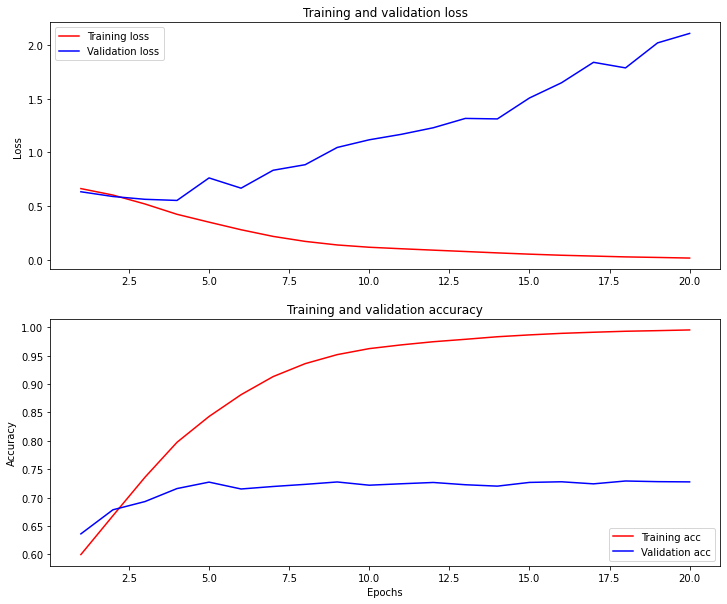

In [ ]:
# Visualisation the accuracy and loss result of the model been trained and Validated
history_dict = cnn_history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# save the trained model
dataset_name = 'bert-cnn_reviews'
saved_model_path = '/content/drive/MyDrive/Msc project/{}_bert'.format(dataset_name.replace('/', '_'))
cnn_classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

933/933 [==============================] - 128s 136ms/step
(29841, 2)


In [ ]:
result[0:2]

array([[0.00009631, 0.9999037 ],
       [0.00010723, 0.9998927 ]], dtype=float32)

In [ ]:
classes = np.argmax(result, axis=-1)

In [ ]:
reviews = []
test_labels = []
predictions = []
for text, labels in test_ds.take(-1):
  text = text.numpy()
  reviews.append(text)
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(text))

1/1 [==============================] - 1s 1s/step


In [ ]:
len(reviews)

933

In [ ]:
# reviews[0:3]

In [ ]:
reviews_list = []
for i in reviews:
    for n in i:
        sentence_n = str(n)
        leng = len(sentence_n)
        text = sentence_n[1:leng+1]
        reviews_list.append(text)

In [ ]:
len(reviews_list)

29841

In [ ]:
# reviews_list[0:3]

In [ ]:
test_labels[0:2]

[array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0]),
 array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0])]

In [ ]:
predictions[0:2]

[array([[0.0011613 , 0.9988387 ],
        [0.0041779 , 0.9958221 ],
        [0.00054452, 0.9994555 ],
        [0.99975485, 0.00024521],
        [0.9999709 , 0.00002911],
        [0.9997986 , 0.00020147],
        [0.00009805, 0.9999019 ],
        [0.99996305, 0.00003696],
        [0.9999765 , 0.00002344],
        [0.99310017, 0.00689982],
        [0.9999168 , 0.00008319],
        [0.00013131, 0.99986863],
        [0.00120028, 0.9987997 ],
        [0.00010449, 0.99989545],
        [0.00009593, 0.99990404],
        [0.99995816, 0.00004182],
        [0.00009635, 0.9999037 ],
        [0.00010344, 0.9998965 ],
        [0.0001035 , 0.9998965 ],
        [0.00010309, 0.9998969 ],
        [0.999966  , 0.00003392],
        [0.0066551 , 0.9933449 ],
        [0.0001132 , 0.99988675],
        [0.9999528 , 0.00004719],
        [0.999966  , 0.00003392],
        [0.9867829 , 0.01321713],
        [0.9998116 , 0.00018847],
        [0.99971443, 0.0002855 ],
        [0.0001046 , 0.99989533],
        [0.999

In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)
# type(y_pred)

In [ ]:
y_test = np.array(list(chain.from_iterable(test_labels)))
# type(y_test)

In [ ]:
DF_pr = pd.DataFrame(y_pred,y_test)
# DF_pr

In [ ]:
DF_pr.to_csv('/content/drive/MyDrive/Msc project/compare_predict.csv',sep=',',index=True)
DF_fin = pd.read_csv("/content/drive/MyDrive/Msc project/compare_predict.csv")
DF_fin

,Unnamed: 0,0
0,0,1
1,0,1
2,1,1
3,0,0
4,1,0
...,...,...
29836,0,0
29837,0,1
29838,0,1
29839,0,0


## Compare the original and prediction result and save into csv file

In [ ]:
DF_fin.rename(columns={'Unnamed: 0' : 'prediction',
                   '0' : 'test'}, 
                    inplace=True)
DF_fin['reviews'] = reviews_list
DF_fin

,prediction,test,reviews
0,0,1,'Instead of fighting the cat with a pill poppe...
1,0,1,"""It seems to help with their digestion and the..."
2,1,1,"""I would have tried this coffee because it is ..."
3,0,0,"""I did not buy these on Amazon. I just picked ..."
4,1,0,'Someone at work cooked these and the smell is...
...,...,...,...
29836,0,0,'This product has a very good taste and I coul...
29837,0,1,"""These are surprisingly good considering how m..."
29838,0,1,"""Who doesn't LOVE chocolate? These lovely litt..."
29839,0,0,"'AKC TREATS , MADE IN CHINA, Please do researc..."


In [ ]:
DF_fin.to_csv('/content/drive/MyDrive/Msc project/compare_final.csv',sep=',',index=False)